https://opensource.salesforce.com/OmniXAI/latest/tutorials/vision/ig_tf.html

In [1]:
import tensorflow as tf


# Get list of available GPU devices
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU is available")
    # Additional information about GPUs
    for gpu in gpu_devices:
        print(gpu)
else:
    print("GPU is not available")

GPU is available
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv("C:/Users/RAZER/Downloads/dataset/aptos/train.csv")
test = pd.read_csv("C:/Users/RAZER/Downloads/dataset/aptos/test.csv")
#submission= pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard


N_CLASSES = train['diagnosis'].nunique()
N_CLASSES




# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()





train_datagen=ImageDataGenerator(rescale=1./255, 
                                validation_split=0.2,
                                horizontal_flip=True)


train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="C:/Users/RAZER/Downloads/dataset/aptos/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",
    target_size=(224, 224),
    subset='training')





valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="C:/Users/RAZER/Downloads/dataset/aptos/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",    
    target_size=(224, 224),
    subset='validation')




test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "C:/Users/RAZER/Downloads/dataset/aptos/test_images/",
        x_col="id_code",
        target_size=(224, 224),
        batch_size=16,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50


import tensorflow as tf
from tensorflow.keras import layers, models

In [5]:
from keras.models import load_model
aptos_resnet_model = load_model("C:/Users/RAZER/Documents/Python Scripts/saved_models/retina/aptos_resnet.h5")

In [6]:
"""loss, accuracy = aptos_resnet_model.evaluate(train_generator)
print("Train loss:", loss, "Train accuracy:", accuracy)

test_loss, test_accuracy = aptos_resnet_model.evaluate(test_generator)
print("Test loss:", test_loss, "Test accuracy:", test_accuracy)

val_loss, val_accuracy = aptos_resnet_model.evaluate(valid_generator)
print("Validation loss:", val_loss, "Val accuracy:", val_accuracy)"""

'loss, accuracy = aptos_resnet_model.evaluate(train_generator)\nprint("Train loss:", loss, "Train accuracy:", accuracy)\n\ntest_loss, test_accuracy = aptos_resnet_model.evaluate(test_generator)\nprint("Test loss:", test_loss, "Test accuracy:", test_accuracy)\n\nval_loss, val_accuracy = aptos_resnet_model.evaluate(valid_generator)\nprint("Validation loss:", val_loss, "Val accuracy:", val_accuracy)'

## Lime


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 8s 8s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


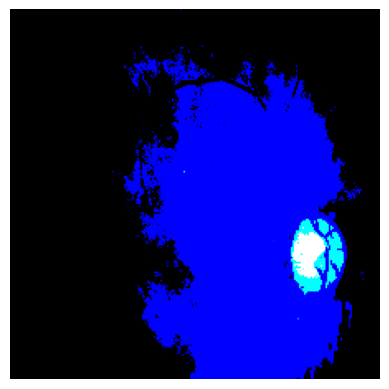

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from lime import lime_image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input


model = load_model("C:/Users/RAZER/Documents/Python Scripts/saved_models/retina/aptos_resnet.h5")

# Load an example image from the APTOS retina dataset
img_path = 'C:/Users/RAZER/Downloads/dataset/aptos/test_images/ff4c945d9b17.png'  
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = preprocess_input(x)
x = np.expand_dims(x, axis=0)

# Define a function to predict with your model
def predict_fn(images):
    preprocessed_images = preprocess_input(images.copy())
    return model.predict(preprocessed_images)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction
explanation = explainer.explain_instance(x[0], predict_fn, top_labels=5, hide_color=0, num_samples=10)

# Show explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.show()


  0%|          | 0/10 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


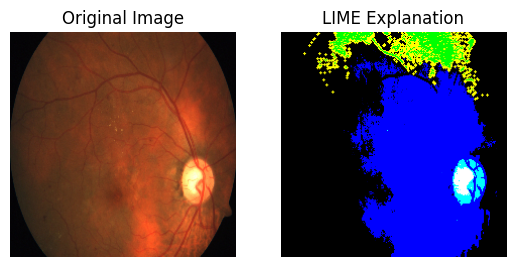

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from lime import lime_image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input


model = load_model("C:/Users/RAZER/Documents/Python Scripts/saved_models/retina/aptos_resnet.h5")

# Load an example image from the APTOS retina dataset
img_path = 'C:/Users/RAZER/Downloads/dataset/aptos/test_images/ff4c945d9b17.png' 
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array and preprocess it
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Define a function to predict with your model
def predict_fn(images):
    preprocessed_images = preprocess_input(images.copy())
    return model.predict(preprocessed_images)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction
explanation = explainer.explain_instance(x[0], model, top_labels=5, hide_color=0, num_samples=10)

# Show the original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Show the LIME explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('LIME Explanation')
plt.axis('off')

plt.show()








  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


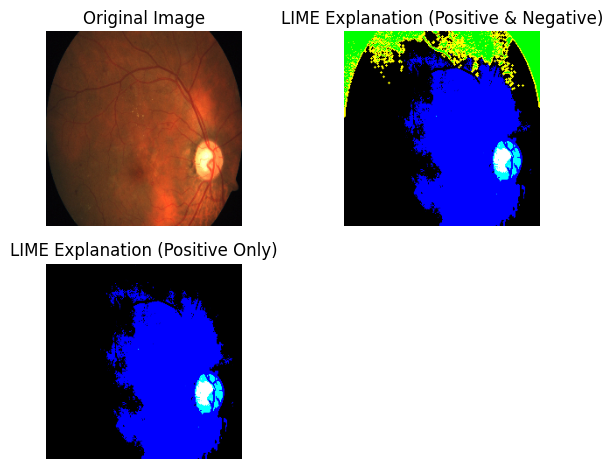

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from lime import lime_image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load your RetinaNet model
model = load_model("C:/Users/RAZER/Documents/Python Scripts/saved_models/retina/aptos_resnet.h5")

# Load an example image from the APTOS retina dataset
img_path = 'C:/Users/RAZER/Downloads/dataset/aptos/test_images/ff4c945d9b17.png'  
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array and preprocess it
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Define a function to predict with your model
def predict_fn(images):
    preprocessed_images = preprocess_input(images.copy())
    return model.predict(preprocessed_images)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction
explanation = explainer.explain_instance(x[0], model, top_labels=5, hide_color=None, num_samples=1000)

# Show the original image
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Show the LIME explanation with positive and negative contributions
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.subplot(2, 2, 2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('LIME Explanation (Positive & Negative)')
plt.axis('off')

# Show the LIME explanation with only positive contributions
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.subplot(2, 2, 3)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('LIME Explanation (Positive Only)')
plt.axis('off')

plt.tight_layout()
plt.show()


## SHAP

In [16]:
import json

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

import shap



data = train_generator.next()
class_names = list(train['diagnosis'].unique())

model = model = load_model("C:/Users/RAZER/Documents/Python Scripts/saved_models/retina/aptos_resnet.h5")



X = data[0]  # Features
y = data[1]  # Labels


X = np.array(X)
y = np.array(y)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)
#masker = shap.maskers.Image("inpaint_ns", X[0].shape)


# create an explainer with model and image masker
explainer = shap.Explainer(model, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X[1:5], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
)


Partition explainer: 5it [00:10, 10.59s/it]               


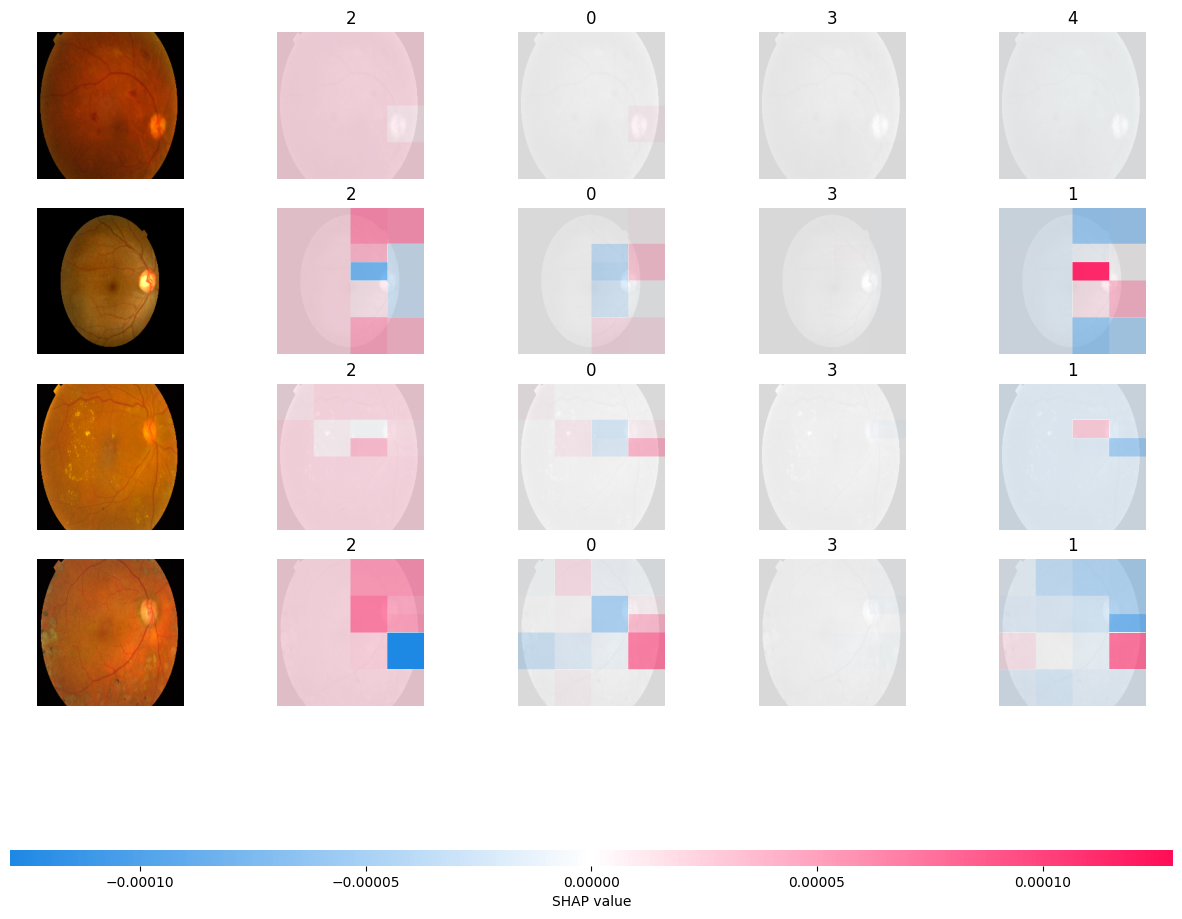

In [17]:
# output with shap values
shap.image_plot(shap_values)

In [14]:




# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(model, masker_blur, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(
    X[1:3], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
)

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 3it [00:35, 17.80s/it]               


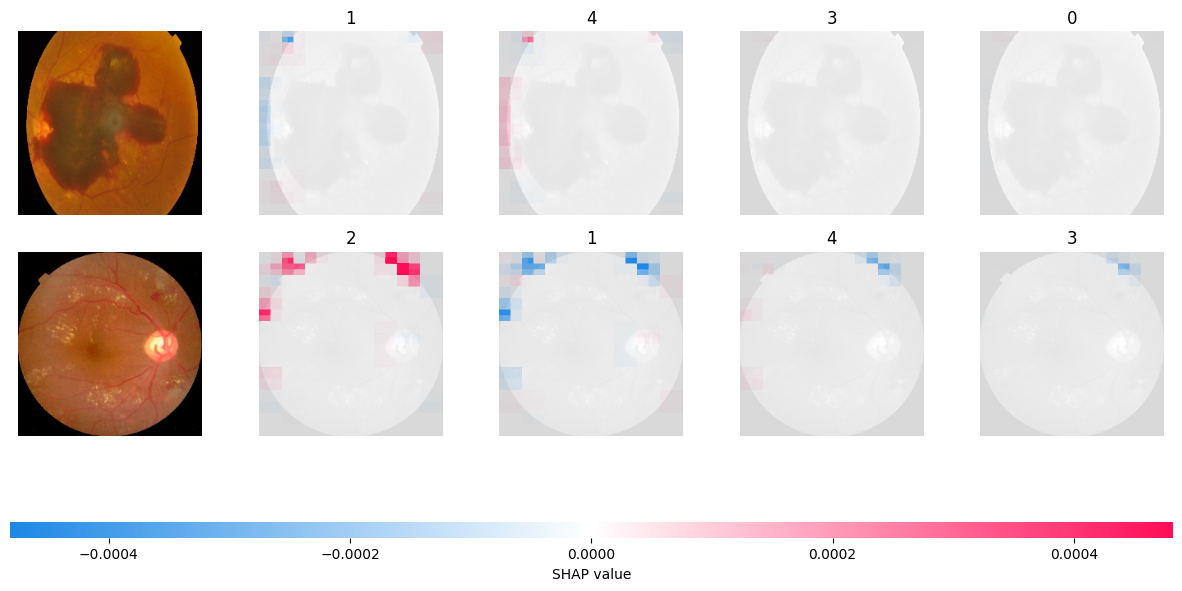

In [15]:
# output with shap values
shap.image_plot(shap_values_fine)

## Grad Cam

In [6]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

aptos_resnet_model = load_model("C:/Users/RAZER/Documents/Python Scripts/saved_models/retina/aptos_resnet.h5")

last_conv_layer_name = "conv5_block3_out"

# The local path to our target image
img_path ="C:/Users/RAZER/Downloads/dataset/aptos/test_images/ff4c945d9b17.png"


display(Image(img_path))



In [19]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


1/1 [==============================] - 0s 42ms/step
Predicted: [[-23.429235  -12.815044    3.5171366   6.106743  -20.191801 ]]


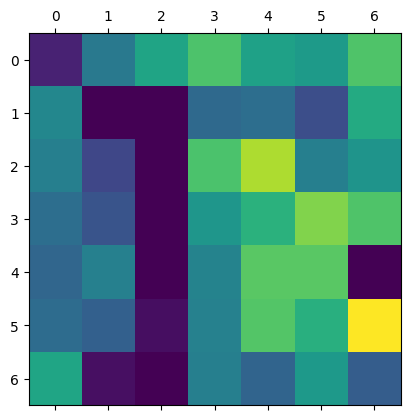

In [22]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = aptos_resnet_model

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


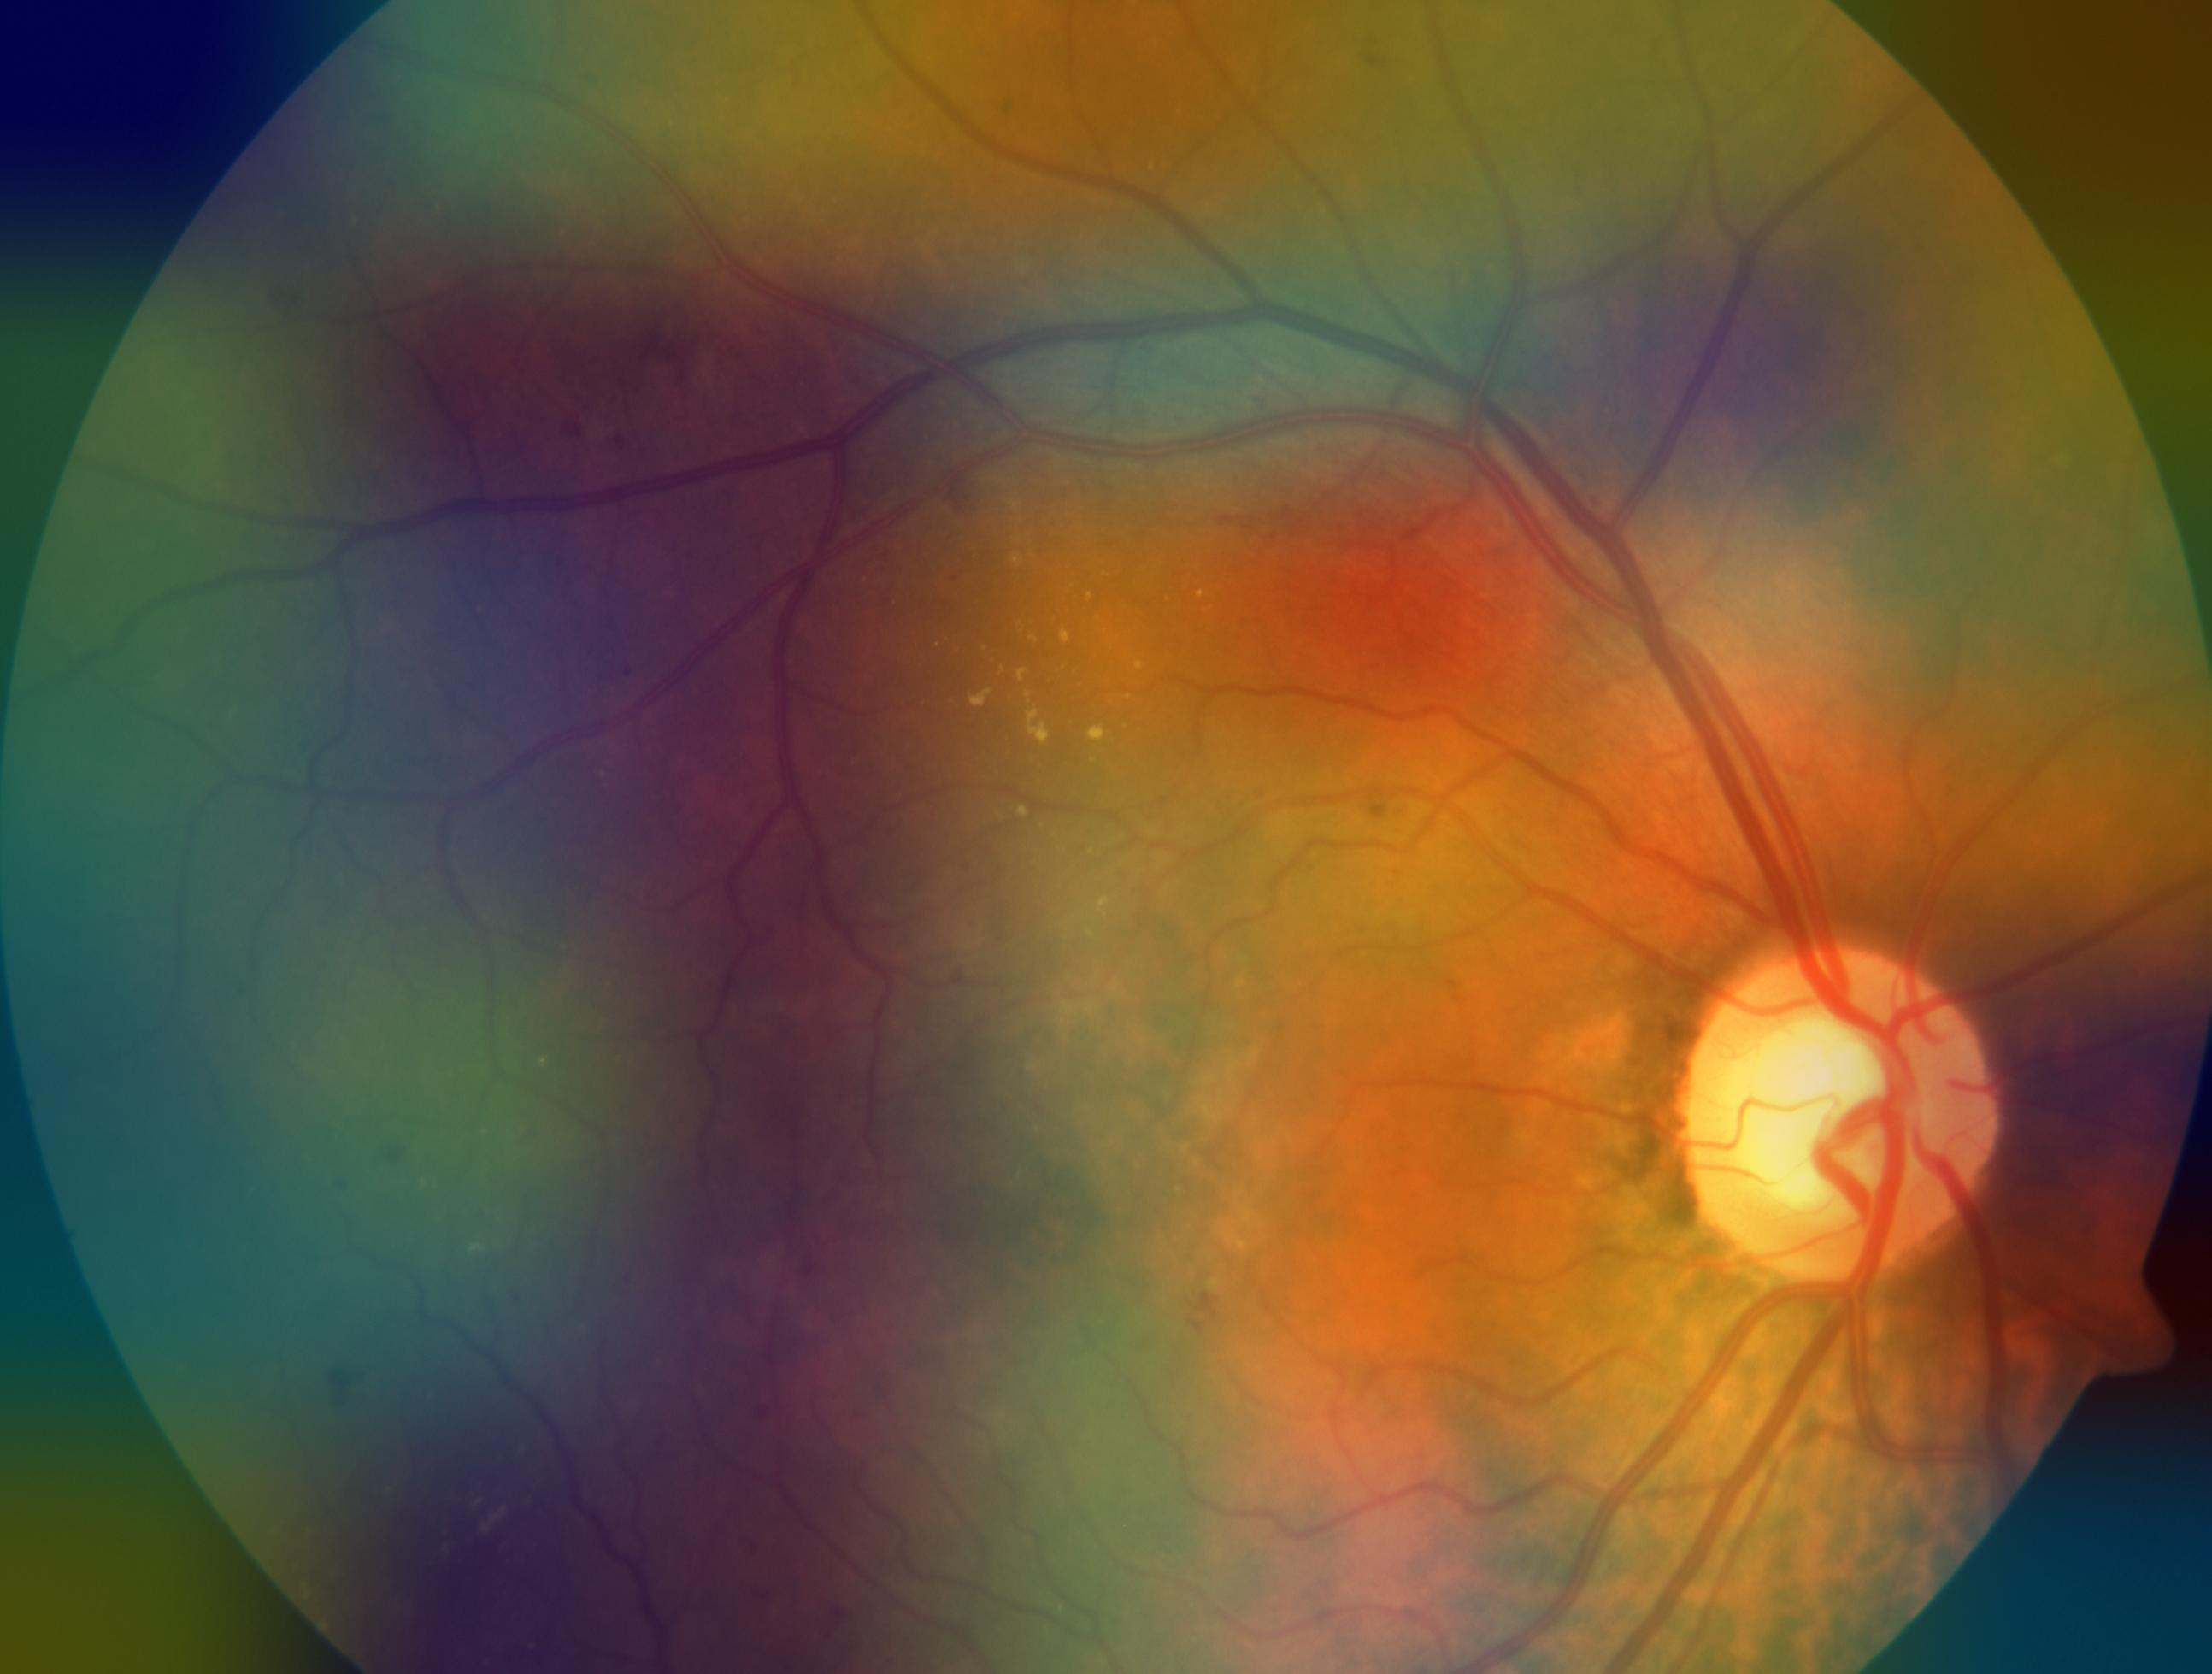

In [23]:
def save_and_display_gradcam(img_path, heatmap, cam_path="C:/Users/RAZER/Desktop/cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

# Adversarial Gradient Integration (AGI)

In [11]:
# Load your RetinaNet model
model = load_model("C:/Users/RAZER/Documents/Python Scripts/saved_models/retina/aptos_resnet.h5")

# Load an example image from the APTOS retina dataset
img_path = 'C:/Users/RAZER/Downloads/dataset/aptos/test_images/ff4c945d9b17.png'  

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def compute_adversarial_gradients(model, input_tensor, target_class):
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        predictions = model(input_tensor)
        loss = predictions[0][target_class]
    gradient = tape.gradient(loss, input_tensor)
    return gradient

def adversarial_gradient_integration(model, input_image, epsilon=0.1, steps=50):
    original_image = input_image.copy()
    input_tensor = tf.convert_to_tensor(input_image)
    for _ in range(steps):
        gradient = compute_adversarial_gradients(model, input_tensor, target_class=np.argmax(model.predict(input_tensor)[0]))
        input_tensor += epsilon * tf.sign(gradient)
    
    integrated_gradient = (input_tensor - original_image) * gradient
    return integrated_gradient.numpy()


# Load and preprocess your input image
input_image = load_and_preprocess_image(img_path)

# Compute AGI
agi_result = adversarial_gradient_integration(model, input_image)


1/1 [==============================] - 0s 27ms/step


c:\Users\RAZER\anaconda3\envs\Viper\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  


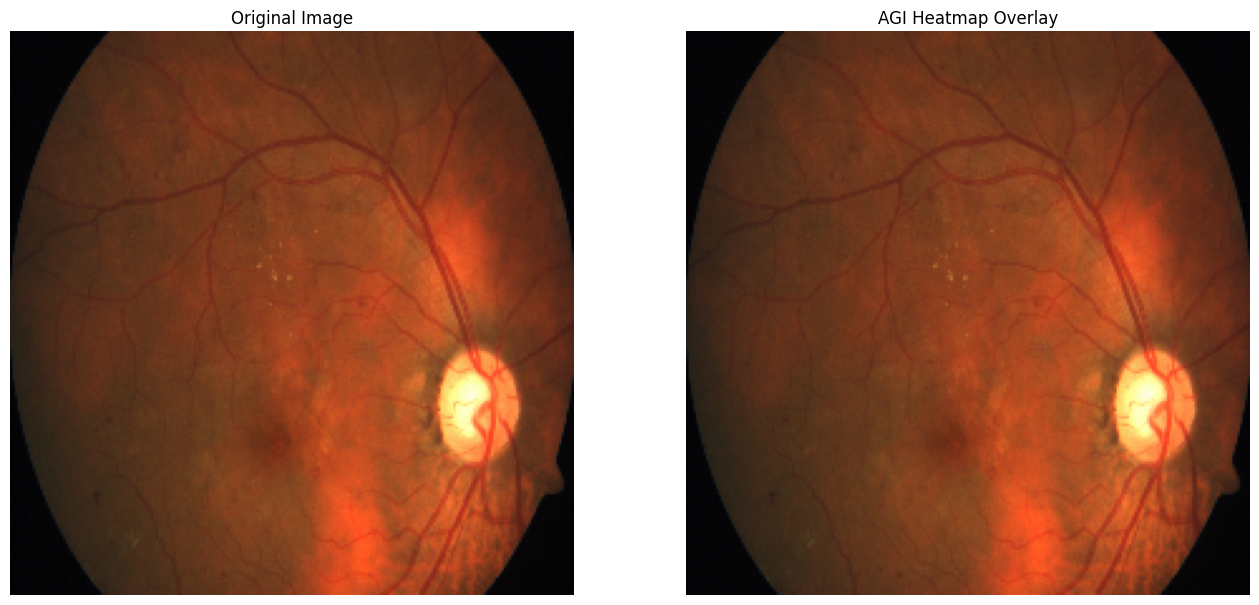

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_original_and_agi_results(original_img, agi_result, alpha=0.4):
    # Remove the batch dimension if present
    if len(original_img.shape) == 4:
        original_img = original_img[0]
    if len(agi_result.shape) == 4:
        agi_result = agi_result[0]

    # Normalize the original image if necessary
    if original_img.max() > 1:
        original_img = original_img / 255.0

    # Normalize the AGI result to [0, 1]
    agi_result = (agi_result - np.min(agi_result)) / (np.max(agi_result) - np.min(agi_result))
    
    # Ensure AGI result is single channel (grayscale) for overlay if not
    if agi_result.shape[-1] == 3:
        agi_result = np.mean(agi_result, axis=-1)

    # Setup plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns of images

    # Plotting the original image
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes ticks

    # Plotting the AGI result
    axes[1].imshow(original_img, cmap='gray')  # Display the original in grayscale
    axes[1].imshow(agi_result, cmap='hot', alpha=alpha)  # Overlay the AGI heatmap
    axes[1].set_title("AGI Heatmap Overlay")
    axes[1].axis('off')  # Hide axes ticks

    plt.show()


original_img = image.load_img(img_path, target_size=(224, 224))
original_img = image.img_to_array(original_img)
plot_original_and_agi_results(original_img, agi_result)


In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path ="C:/Users/RAZER/Desktop/grad_cam_4_0.png"

"""keras.utils.get_file(
    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
)"""

display(Image(img_path))

In [8]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



1/1 [==============================] - 6s 6s/step
Predicted: [('n02504458', 'African_elephant', 9.861372)]


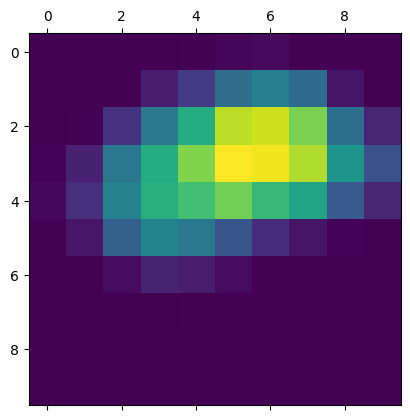

In [9]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


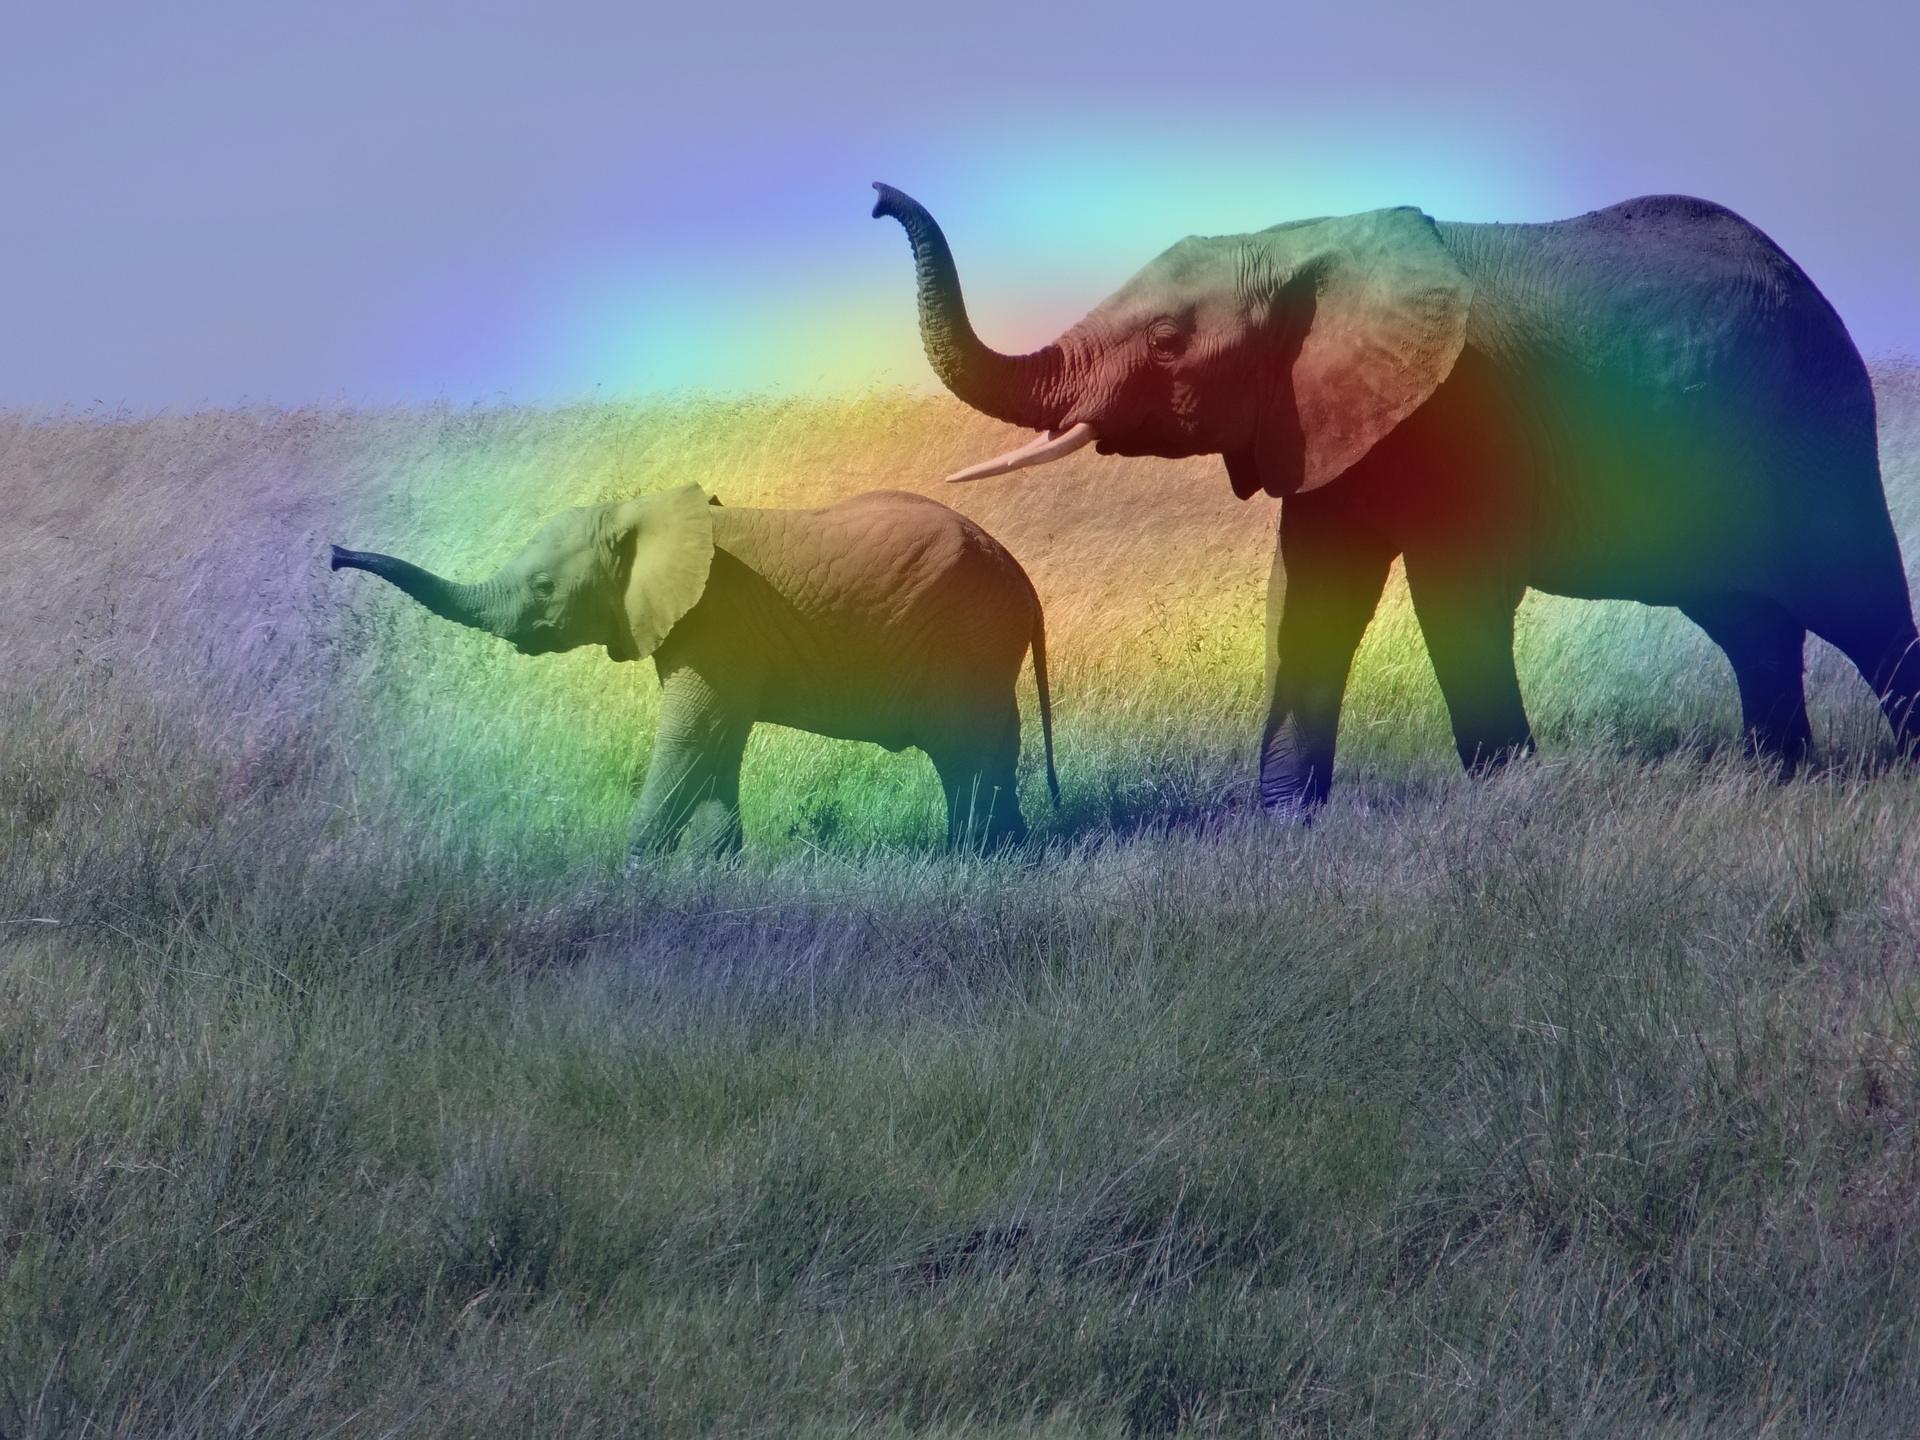

In [10]:
def save_and_display_gradcam(img_path, heatmap, cam_path="C:/Users/RAZER/Desktop/cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

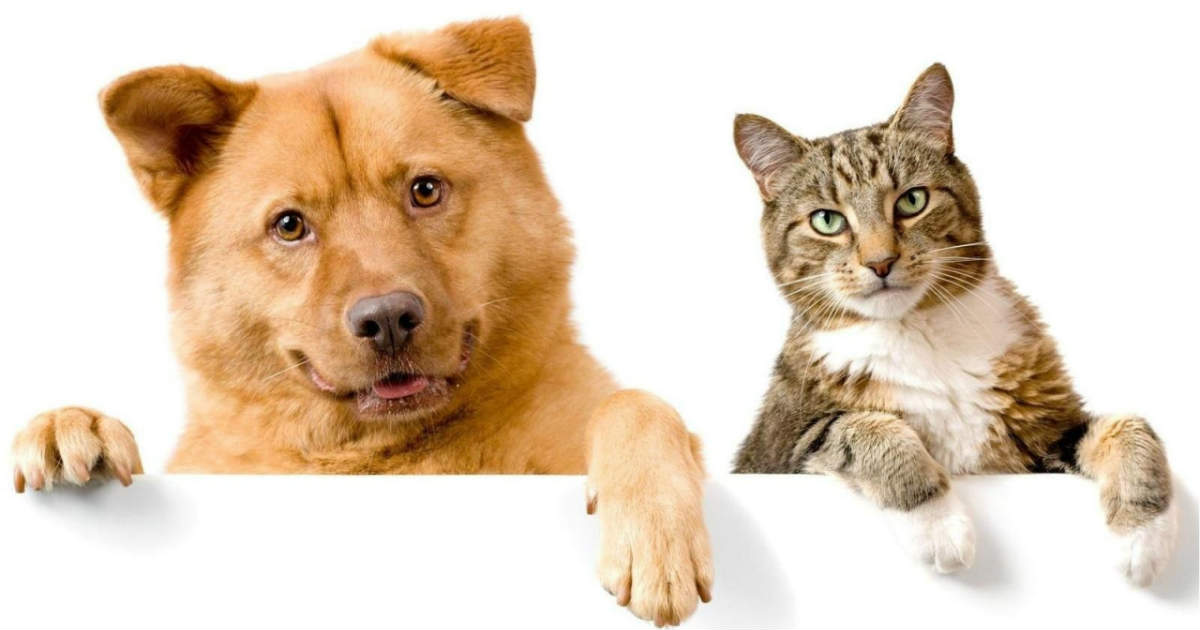

1/1 [==============================] - 0s 37ms/step
Predicted: [('n02112137', 'chow', 4.6109967), ('n02124075', 'Egyptian_cat', 4.383563)]


In [11]:
img_path = "C:/Users/RAZER/Desktop/grad_cam_12_0.jpg"

"""keras.utils.get_file(
    "cat_and_dog.jpg",
    "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",
)"""

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

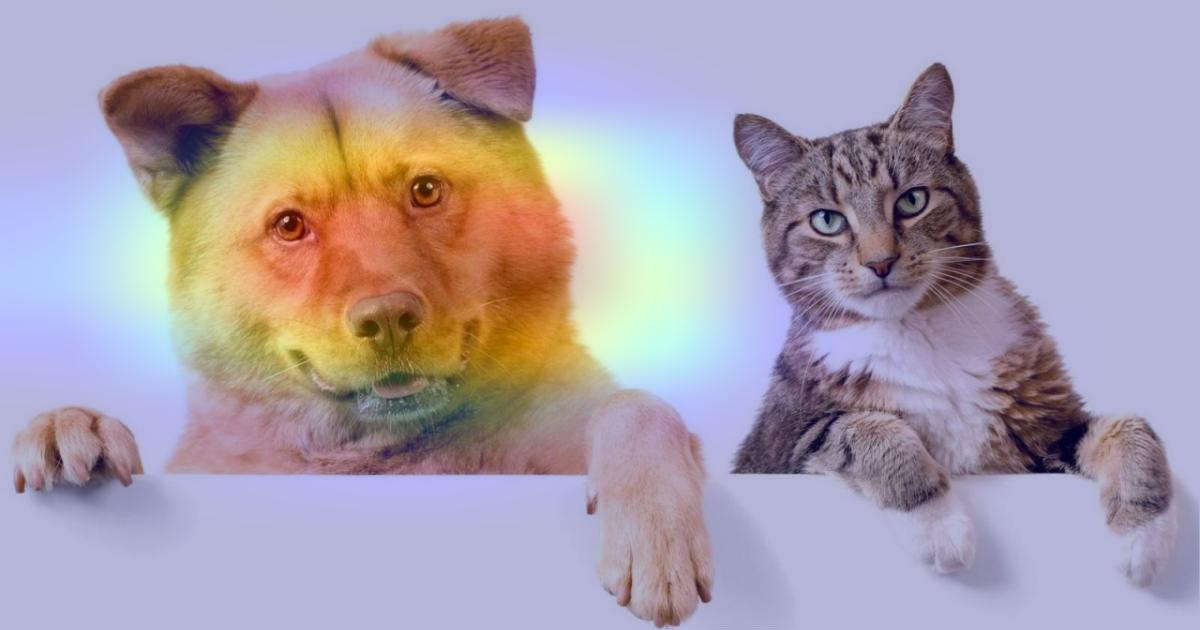

In [12]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=260)

save_and_display_gradcam(img_path, heatmap)

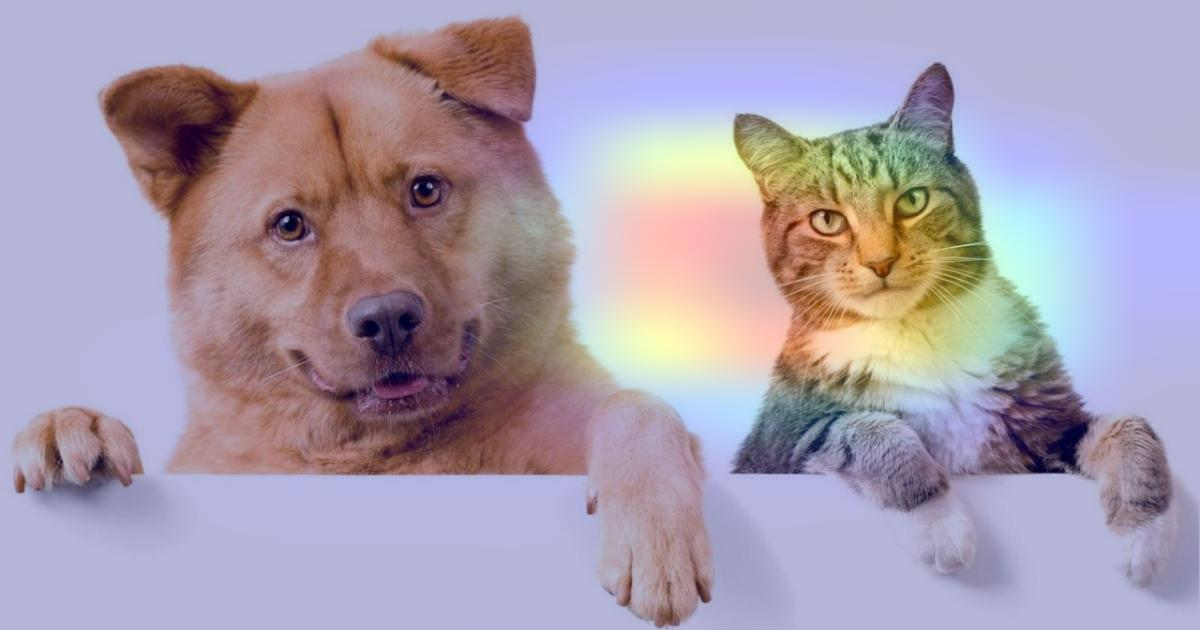

In [37]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)

save_and_display_gradcam(img_path, heatmap)